<a href="https://colab.research.google.com/github/yashlal/Deepfake-Microbiomes/blob/main/OrdinationPlot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA device selected!
Using 1 GPU


Epoch 0: Loss 0.5771619230163968
Epoch 10: Loss 0.5506132383070741
Epoch 20: Loss 0.5210951441207505
Epoch 30: Loss 0.4895039793468061
Epoch 40: Loss 0.45545306855084833
Epoch 50: Loss 0.4184211174173504
Epoch 60: Loss 0.37993645834616047
Epoch 70: Loss 0.33887305898711695
Epoch 80: Loss 0.2982179535785099
Epoch 90: Loss 0.25435641408112925
Epoch 100: Loss 0.21600088616421123
Epoch 110: Loss 0.17705332532085344
Epoch 120: Loss 0.14773008730044826
Epoch 130: Loss 0.11438363527769536
Epoch 140: Loss 0.08824629570265125
Epoch 150: Loss 0.06857880920631843
Epoch 160: Loss 0.054708509225805224
Epoch 170: Loss 0.03881136345641054
Epoch 180: Loss 0.028175356477277407
Epoch 190: Loss 0.023336925908921318
Epoch 200: Loss 0.015023806463345219
Epoch 210: Loss 0.01097354281114718
Epoch 220: Loss 0.008898740081480474
Epoch 230: Loss 0.0061640729867169074
Epoch 240: Loss 0.005340004359319169
Epoch 250: Loss 0.005464593085352163
Epoch 260: Loss 0.00284767010853018
Epoch 270: Loss 0.002128699426102654

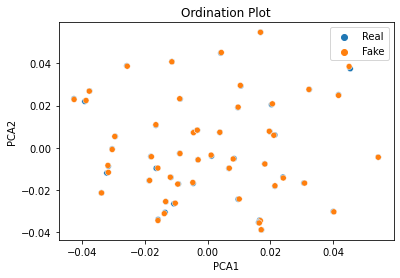

In [ ]:
from newsolver import predict_community_fullnp
import numpy as np
import pandas as pd
import random as rd
from numba import njit
from numba.typed import List
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import time
from math import sqrt
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from modules import *
from scipy.stats import wasserstein_distance as WD
from sklearn.decomposition import PCA 
import seaborn as sns

data = pd.read_excel('RealData.xlsx', index_col=0)
specs = data.columns.tolist()
trimmed_specs = []
typed_trimmed_specs = List()
prob_distro = {}

pca = PCA(n_components=2)

for i in range(len(specs)):
    if data.iloc[:,i].astype(bool).sum() >= 85:
        trimmed_specs.append(specs[i])
        prob_distro[specs[i]] = data.iloc[:,i].astype(bool).sum() / (849)
        typed_trimmed_specs.append(specs[i])

# select CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == 'cuda:0':
    print('CUDA device selected!')
elif str(device) == 'cpu':
	print('CUDA device not available. CPU selected')

class MyNet(nn.Module):
    def __init__(self, hyperparam):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(462, hyperparam)
        self.fc2 = nn.Linear(hyperparam, 231*461)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def test_net(model, test_size, Lambda_Mat, prob_distro):
    testing_communities_for_pca = []
    labels = []
    for epoch in range(test_size):
        npcm1 = np.zeros(462)
        npcm2 = np.zeros(462)
        subset = []
        for sp in trimmed_specs:
            bin = genrand(prob_distro[sp])
            if bin:
                subset.append(sp)
        subset_lam = (Lambda_Mat.loc[subset, subset]).to_numpy()
        cm = predict_community_fullnp(subset_lam, subset, verb=False)
        for i in range(len(cm)):
            npcm1[trimmed_specs.index(subset[i])] = cm[i]

        input = torch.from_numpy(npcm1).float().to(device)
        true_y = torch.FloatTensor(get_LT(Lambda_Mat.to_numpy())).to(device)
        output = model(input).to(device)
        loss1 = criterion(output, true_y)
        s = sqrt(loss1.item()/(231*461))
        lam_pred = (pd.DataFrame(regenerate_PWMatrix(output.tolist(), 462), index=trimmed_specs, columns=trimmed_specs).loc[subset, subset]).to_numpy()
        cm_pred = predict_community_fullnp(lam_pred, subset, verb=False)
        for i in range(len(cm_pred)):
            npcm2[trimmed_specs.index(subset[i])] = cm_pred[i]
        loss2 = WD(cm, cm_pred)
        testing_communities_for_pca.append(npcm1.tolist())
        labels.append('Real')
        testing_communities_for_pca.append(npcm2.tolist())
        labels.append('Fake')
        print(f'Testing Epoch {epoch}')
        print(f'Lambda Loss is {s}')
        print(f'Community Loss is {loss2}')
    transformed_data = pca.fit_transform(testing_communities_for_pca)
    return transformed_data, labels

def train_net(model, train_size):
    train_communities_for_pca = []
    full_m = pd.DataFrame(generate_matrix(typed_trimmed_specs), index=trimmed_specs, columns=trimmed_specs)
    train_y = get_LT(full_m.to_numpy())
    loss_values = []
    pbar2=tqdm(range(train_size))
    pbar2.set_description('Training Neural Net')
    for epoch in pbar2:

        npcm = np.zeros(len(trimmed_specs))
        size = rd.randint(25, 235)
        subset = rd.sample(trimmed_specs, size)
        subset_lam = (full_m.loc[subset, subset]).to_numpy()
        cm = predict_community_fullnp(subset_lam, subset, verb=False)
        


        for i in range(len(cm)):
            npcm[trimmed_specs.index(subset[i])] = cm[i]

        optimizer.zero_grad()

        x, y = npcm, train_y
        train_communities_for_pca.append(x)
        input = torch.from_numpy(x).float().to(device)
        true_y = torch.FloatTensor(y).to(device)
        output = model(input).to(device)
        loss = criterion(output, true_y).to(device)
        s = sqrt(loss.item()/(231*461))
        if (epoch % 10)==0:
          print(f'Epoch {epoch}: Loss {s}')
        loss_values.append(s)
        loss.backward()
        optimizer.step()
    pca.fit(train_communities_for_pca)
    return loss_values, train_y

if __name__=='__main__':
    train_size, test_size, param = 3000, 50, 2500
    path = 'model.pth'

    net = MyNet(param).to(device)

    #Multi GPU Support
    if torch.cuda.device_count() > 1:
          print(f'Using {torch.cuda.device_count()} GPUs')
          net = nn.DataParallel(net)
    elif torch.cuda.device_count() == 1:
        print(f'Using {torch.cuda.device_count()} GPU')

    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    lv, full_lam = train_net(net, train_size=train_size)
    full_lam = pd.DataFrame(np.array(regenerate_PWMatrix(full_lam, 462)), index=trimmed_specs, columns=trimmed_specs)
    transformed_data, labels = test_net(model=net, test_size=test_size, Lambda_Mat=full_lam, prob_distro=prob_distro)
    df = pd.DataFrame(transformed_data, columns=['PCA1', 'PCA2'])
    torch.save(net.state_dict(), path)

    ax0 = sns.scatterplot(data=df, x='PCA1', y='PCA2', hue=labels)
    ax0.set(title='Ordination Plot', xlabel='PCA1', ylabel='PCA2')

    plt.savefig('Ordination Plot')
    plt.show()
